In [8]:
import sys
sys.path.append('../src')

from collections import Counter
import localmodule
import functools
from joblib import Memory, Parallel, delayed
from librosa.display import specshow
import math
import music21 as m21
import numpy as np
import os
import scipy

In [9]:
composer_str = "Haydn"
track_str = "op71n2-04"

# Define constants.
J_tm = 9
N = 2**10
n_octaves = 8
midi_octave_offset = 2
quantization = 2.0
xi = 0.4
sigma = 0.16

midis = []

# Parse Kern score with music21.
#data_dir = localmodule.get_data_dir()
data_dir = '/Users/vl238/nemisig2018/nemisig2018_data'
dataset_name = localmodule.get_dataset_name()
kern_name = "_".join([dataset_name, "kern"])
kern_dir = os.path.join(data_dir, kern_name)
composer_dir = os.path.join(kern_dir, composer_str)
track_name = track_str + ".krn"
track_path = os.path.join(composer_dir, track_name)
score = m21.converter.parse(track_path)
pianoroll_parts = []
n_parts = len(score.parts)
n_semitones = 12 * n_octaves

# Loop over parts to extract piano rolls.
for part_id in range(n_parts):
    part = score.parts[part_id]
    pianoroll_part = np.zeros((n_semitones, N))
    
    # Get the measure offsets
    measure_offset = {}
    for el in part.recurse(classFilter=('Measure')):
        measure_offset[el.measureNumber] = el.offset
    
    # Loop over notes
    for note in part.recurse(classFilter=('Note')):
        note_start = int(math.ceil(
                (measure_offset[note.measureNumber] +\
                 note.offset) *\
            quantization))
        note_end = int(math.ceil((
                measure_offset[note.measureNumber] +\
                note.offset +\
                note.duration.quarterLength) *\
            quantization))
        pianoroll_part[
            note.midi - midi_octave_offset * 12,
            note_start:note_end] = 1
        midis.append(note.midi)
    pianoroll_parts.append(pianoroll_part)
    
# Stack parts into piano roll.
mtrack_pianoroll = np.stack(pianoroll_parts, 2)
pianoroll = mtrack_pianoroll.max(axis=2)

# Setup wavelet filter bank over time.
wavelet_filterbank_ft = np.zeros((1, N, J_tm))
for j in range(J_tm-1):
    xi_j = xi * 2**(-j)
    sigma_j = sigma * 2**(-j)
    center = xi_j * N
    den = 2 * sigma_j * sigma_j * N * N
    psi_ft = localmodule.morlet(center, den, N, n_periods=4)
    conj_psi_ft = np.roll(psi_ft, -1)[::-1]
    wavelet_filterbank_ft[0, :, -1 - j] = psi_ft
    
# Append scaling function phi (average).
wavelet_filterbank_ft[0, 0, 0] = 1

# Convolve pianoroll with filterbank.
pianoroll_ft = scipy.fftpack.fft(pianoroll, axis=1)
pianoroll_ft = np.expand_dims(pianoroll_ft, axis=2)
wavelet_transform_ft = pianoroll_ft * wavelet_filterbank_ft
wavelet_transform = scipy.fftpack.ifft(wavelet_transform_ft, axis=1)


In [10]:
# Reshape MIDI axis to chromagram
chromagram = np.reshape(wavelet_transform,
    (12, -1, wavelet_transform.shape[1], wavelet_transform.shape[2]), 'F')

# Construct eigentriads
cosine_basis = np.array([[np.cos(2*np.pi*omega*t/3) for omega in range(3)] for t in range(3)]).T
sine_basis = np.array([[np.sin(2*np.pi*omega*t/3) for omega in range(3)] for t in range(3)]).T
fourier_basis = cosine_basis + np.complex(0, 1) * sine_basis
major_template = [0, 4, 7]
minor_template = [0, 3, 7]
major_eigentriads = np.zeros((12, 3), dtype=np.complex)
minor_eigentriads = np.zeros((12, 3), dtype=np.complex)
for omega in range(3):
    for t, p in enumerate(major_template):
        major_eigentriads[p, omega] = fourier_basis[t, omega]
    for t, p in enumerate(minor_template):
        minor_eigentriads[p, omega] = fourier_basis[t, omega]
eigentriads = np.stack(
    (major_eigentriads, minor_eigentriads), axis=1)

# Convolve chromagram with eigentriads
chromagram_ft = scipy.fftpack.fft(chromagram, axis=0)
chromagram_ft = chromagram_ft[:, np.newaxis, :, :, :, np.newaxis]
eigentriads_ft = scipy.fftpack.fft(eigentriads, axis=0)
eigentriads_ft = eigentriads_ft[:, :, np.newaxis,
    np.newaxis, np.newaxis, :]
eigentriad_transform_ft = chromagram_ft * eigentriads_ft
eigentriad_transform = scipy.fftpack.fft(
    eigentriad_transform_ft, axis=0)

# Apply modulus nonlinearity
eigentriad_transform_modulus = np.abs(eigentriad_transform)

# Convolve eigentriad transform with filterbank again.
# This is akin to a scattering transform.
# We remove the finest scale (last two coefficients).
eigentriad_transform_modulus_ft = scipy.fftpack.fft(eigentriad_transform_modulus, axis=3)
eigentriad_transform_modulus_ft = eigentriad_transform_modulus_ft[:, :, :, :, :, :, np.newaxis]
scattering_filterbank_ft = wavelet_filterbank_ft[:, np.newaxis, np.newaxis, :, np.newaxis, np.newaxis, :-2]
scattering_transform_ft = eigentriad_transform_modulus_ft * scattering_filterbank_ft
scattering_transform = scipy.fftpack.ifft(scattering_transform_ft, axis=3)


In [4]:
scattering_transform.shape

(12, 2, 8, 1, 9, 3, 7)

In [5]:
# Reshape chroma and quality into a chord axis
sc_shape = scattering_transform.shape
tonnetz_shape = (
    sc_shape[0]*sc_shape[1], sc_shape[2],
    sc_shape[3], sc_shape[4], sc_shape[5],
    sc_shape[6])
tonnetz = np.reshape(scattering_transform,
    tonnetz_shape, 'F')

# Build adjacency matrix for Tonnetz graph
# (1/3) Major to minor transitions.
major_edges = np.zeros((12,))
# Parallel minor (C major to C minor)
major_edges[0] = 1
# Relative minor (C major to A minor)
major_edges[9] = 1
# Leading tone minor (C major to E minor)
major_edges[4] = 1
# (2/3) Minor to major transitions
minor_edges = np.zeros((12,))
# Parallel major (C minor to C major)
minor_edges[0] = 1
# Relative major (C minor to Eb major)
minor_edges[3] = 1
# Leading tone major (C major to Ab minor)
minor_edges[8] = 1
# (2/3) Build full adjacency matrix by 4 blocks.
major_adjacency = scipy.linalg.toeplitz(major_edges, minor_edges)
minor_adjacency = scipy.linalg.toeplitz(minor_edges, major_edges)
tonnetz_adjacency = np.zeros((24,24))
tonnetz_adjacency[:12, 12:] = minor_adjacency
tonnetz_adjacency[12:, :12] = major_adjacency

# Define Laplacian on the Tonnetz graph.
tonnetz_laplacian = 3 * np.eye(24) - tonnetz_adjacency

# Compute eigenprogressions, i.e. eigenvectors of the Tonnetz Laplacian
eigvecs, eigvals = np.linalg.eig(tonnetz_laplacian)

# Diagonalize Laplacian.
eigvals, eigvecs = np.linalg.eig(tonnetz_laplacian)
sorting_indices = np.argsort(eigvals)
eigvals = eigvals[sorting_indices]
eigvecs = eigvecs[:, sorting_indices]

# Key invariance
phi = eigvecs[:, 0]

# Tonic invariance with quality covariance
psi_quality = eigvecs[:, 23]

# C -> C# -> D ... simultaneously with Cm -> C#m -> ...
# Major third periodicity.
psi_chromatic = eigvecs[:, 1] + 1j * eigvecs[:, 2]

# Major keys: pentatonic pattern (C D F G A) moving up a minor third.
# Major keys: minor seventh pattern (B D E A) moving down a minor third.
psi_pentatonic_up = eigvecs[:, 3] + 1j * eigvecs[:, 4]

# Cm -> B -> Bm -> Bb -> Am -> ...
# Minor third periodicity
psi_Cm_B_Bm_Bb = eigvecs[:, 5] + 1j * eigvecs[:, 6]

# C -> Am -> A -> Cm -> C ...
# Relative (R) followed by parallel (P).
# Major third periodicity
j = np.complex(np.cos(2*np.pi/3), np.sin(2*np.pi/3))
jbar = np.complex(np.cos(-2*np.pi/3), np.sin(-2*np.pi/3))
psi_RP = eigvecs[:, 7] + j * eigvecs[:, 8] + jbar * eigvecs[:, 9]

# C -> Bm -> Bb -> Am -> Ab -> ... 
psi_C_Bm_Bb_Am = eigvecs[:, 10] + 1j * eigvecs[:, 11]

# Upwards minor third. Qualities in phase opposition.
psi_minorthird_quality = eigvecs[:, 12] + 1j * eigvecs[:, 13]

# Ab is simultaneous with Am.
# Abstract notion of "third" degree with quality invariance?
# Tritone periodicity
j = np.complex(np.cos(2*np.pi/3), np.sin(2*np.pi/3))
jbar = np.complex(np.cos(-2*np.pi/3), np.sin(-2*np.pi/3))
psi_third_tritone = eigvecs[:, 14] + j * eigvecs[:, 15] + jbar * eigvecs[:, 16]

# C -> C#m -> D -> D#m -> ...
# Minor third periodicity.
psi_C_Dbm_D_Ebm = eigvecs[:, 17] + 1j * eigvecs[:, 18]

# Major keys: pentatonic pattern (C D F G A) moving down a minor third.
# Major keys: minor seventh pattern (B D E A) moving up a minor third.
psi_pentatonic_down = eigvecs[:, 19] + 1j * eigvecs[:, 20]

# C is simultaneous with Dm.
# Abstract notion of minor key?
# Major third periodicity.
psi_minorkey = eigvecs[:, 21] + 1j * eigvecs[:, 22]

# Concatenate eigenprogressions.
eigenprogressions = np.stack((
    phi,
    psi_quality,
    psi_chromatic,
    psi_pentatonic_up,
    psi_Cm_B_Bm_Bb,
    psi_RP,
    psi_C_Bm_Bb_Am,
    psi_C_Bm_Bb_Am,
    psi_minorthird_quality,
    psi_third_tritone,
    psi_C_Dbm_D_Ebm,
    psi_pentatonic_down,
    psi_minorkey), axis=-1)
eigenprogressions = np.reshape(
    eigenprogressions, (12, 2, -1), 'F')


# Apply eigenprogression transform.
scattering_transform_ft = scipy.fftpack.fft(scattering_transform, axis=0)
scattering_transform_ft = scattering_transform_ft[:, :, :, :, :, :, :, np.newaxis]
eigenprogressions_ft = scipy.fftpack.fft(eigenprogressions, axis=0)
eigenprogressions_ft = eigenprogressions_ft[
    :, :, np.newaxis, np.newaxis, np.newaxis, np.newaxis, np.newaxis]
eigenprogression_transform_ft = scattering_transform_ft * eigenprogressions_ft
eigenprogression_transform = scipy.fftpack.ifft(eigenprogression_transform_ft, axis=0)


# Setup wavelet filter bank across octaves.
# This is comparable to a spiral scattering transform.
J_oct = 3
octave_filterbank_ft = np.zeros((n_octaves, 2*J_oct-1))
for j in range(J_oct-1):
    xi_j = xi * 2**(-j)
    sigma_j = sigma * 2**(-j)
    center = xi_j * n_octaves
    den = 2 * sigma_j * sigma_j * n_octaves * n_octaves
    psi_ft = localmodule.morlet(center, den, n_octaves, n_periods=4)
    conj_psi_ft = np.roll(psi_ft, -1)[::-1]
    octave_filterbank_ft[:, -1 - 2*j] = psi_ft
    octave_filterbank_ft[:, -1 - (2*j+1)] = conj_psi_ft
octave_filterbank_ft[0, 0] = 1
octave_filterbank_ft = octave_filterbank_ft[
    np.newaxis, np.newaxis, :,
    np.newaxis, np.newaxis,
    np.newaxis, np.newaxis, np.newaxis]


# Apply octave transform.
eigenprogression_transform_ft = scipy.fftpack.fft(
    eigenprogression_transform, axis=2)
eigenprogression_transform_ft = eigenprogression_transform_ft[
    :, :, :, :, :, :, :, :, np.newaxis]
octave_transform_ft =\
    eigenprogression_transform_ft * octave_filterbank_ft
octave_transform = scipy.fftpack.fft(
    octave_transform_ft, axis=2)

# Apply second-order modulus nonlinearity.
U2 = np.abs(octave_transform)

# Average over time, chroma, and octave.
S2 = np.sum(U2, axis=(0, 2, 3))

In [38]:
# OUTPUTS
# Qualities.
# Dim 2.
S0 = S2[:, 0, 0, 0, 0, 0]

# Wavelet transform modulus
# Dim 17*2 = 24.
S1 = S2[:, :, 0, 0, 0, 0]

# Major eigentriads.
# Dim 17*3 = 51.
S1_maj_eigentriads = S2[0, :, :, 0, 0, 0]

# Eigentriads.
# Dim 2*17*3 = 102.
S1_eigentriads = S2[:, :, :, 0, 0, 0]

# Scattering transform.
# Dim 2*17*3*15 = 1530.
S2_scattering = S2[:, :, :, :, 0, 0]

# Eigenprogressions.
# Dim 2*17*3*13 = 1326.
S2_eigenprogressions = S2[:, :, :, 0, :, 0]

# Scattered eigenprogressions.
# Dim 2*17*3*15*13 = 19890.
S2_scattered_eigenprogressions = S2[:, :, :, :, :, 0]

# Time-octave transform.
# Dim 2*17*3*15*5 = 7650.
S2_time_octave_transform = S2[:, :, :, :, 0, :]

# Spiral eigenprogression transform!
# Dim 2*17*3*15*13*5 = 99450.
S2_spiral_eigenprogression_transform = S2

(2, 17, 3, 15, 13, 5)

In [43]:
U2.shape

(12, 2, 8, 1, 17, 3, 15, 13, 5)

NameError: name 'Y' is not defined

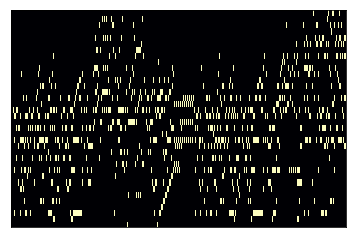

<Figure size 432x288 with 0 Axes>

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure()
specshow(pianoroll[24:60, :512])
for j in range(3, 8):
    plt.figure()
    specshow(np.real(Y[24:60, :512, j]))


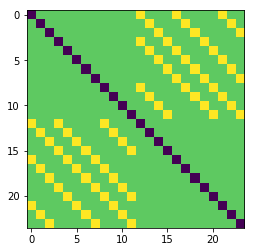

In [11]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(-tonnetz_laplacian)

In [181]:
eigenarpeggios_ft.shape

(12, 2, 3)

In [35]:
x = [2, 3, 4]
x[-3]

2

In [148]:
minor_template

[1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]